<a href="https://colab.research.google.com/github/armand010/PembMesin_Ganjil_2024/blob/main/kuis1ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

Pada kuis ini, Anda diminta untuk melakukan klasifikasi citra wajah dengan menggunakan dataset Labeled Face in Wild (LFW).
Spesifikasi pengerjaan kuis yang harus dipehuni adalah,

1. Setiap label dari dataset LFW harus berisikan minimal 10 gambar (5 poin)
2. Citra yang digunakan merupakan citra RGB / color (5 poin)
3. (Opsional) Lakukan proses pra pengolahan data jika diperlukan (ekstra 10 poin)
4. (Wajib) Gunakan fitur histogram untuk setiap channel citra (35 poin)
5. (Wajib) Gunakan algoritma SVM sebagai model dasar (35 poin)
6. (Wajib) Gunakan metric akurasi, dan *classification report* untuk melihat performa model (20 poin)

## Challenge
Setelah menyelesaikan kuis berdasarkan spesifikasi wajib, Anda diperkenankan untuk

- Menggunakan fitur lain selain histogram (ekstra 20 poin)
- Menggunakan model lain selain SVM (ekstra 10 poin)
- Evalusi dengan metric lain ataupun report dengan *confusion matrix* (ekstra 10 poin)

# Boilerplate

Berikut merupakan boilerplate code yang dapat Anda gunakan sebagai acuan dasar pengerjaan kuis.
Anda diperkenankan untuk **menambah** ataupun **mengurangi** bagian boilerplate yang disediakan.

# Preparation

In [1]:
# Load required library
# Import Required Library
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [2]:
# Load Dataset
# We will load dataset only for faces with contain min 10 images
# We also want to keep images in color; color=True
faces = fetch_lfw_people(min_faces_per_person=10, color=True) # Mengambil data wajah yang muncul 10 kali dalam dataset (berwarna)

# Check Faces
print(f'Total Label: {len(faces.target_names)}')
print(f'Data dimension: {faces.images.shape}')
print(f'Images flatten dimension: {faces.data.shape}')

Total Label: 158
Data dimension: (4324, 62, 47, 3)
Images flatten dimension: (4324, 8742)


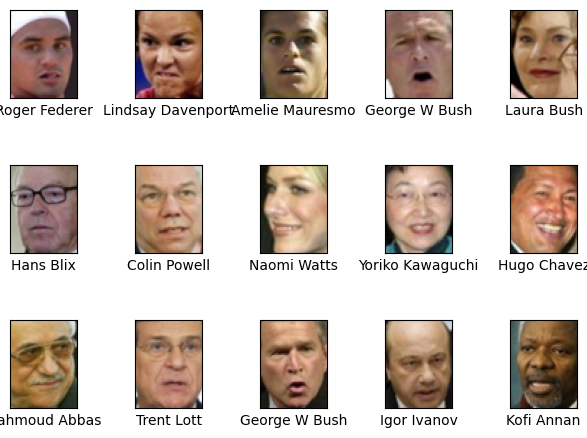

In [3]:
# Check by Plotted Images
# Generate random 15 images
rand_labels = [np.random.randint(0, len(faces.data)) for x in range(0,15)] # Mencari angka random sebanyak 15 dari 0 - banyak data pada dataset

fig, ax = plt.subplots(3, 5)
fig.tight_layout()
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[rand_labels[i]], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[rand_labels[i]]])

# Preprocecing


Pada bagian ini Anda diperbolehkan untuk melakukan proses pra pengolahan data (preprocessing) sesuai dengan kebutuhan. Pra pengolahan data dapat berupa,
    
1. Standardisasi nilai fitur ataupun label
2. Penyesuaian ukuran gambar
3. Perubahan colorspace gambar
4. dsb


In [4]:
from sklearn.preprocessing import StandardScaler
from skimage.color import rgb2gray
import cv2

In [5]:
# Normalisasi Data
def normalize_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

# Resize Gambar
def resize_images(images, size=(100, 100)):
    resized_images = [cv2.resize(img, size) for img in images]
    return np.array(resized_images)

# Normalisasi semua data
faces_normalized = normalize_data(faces.data)

# Resize gambar ke 100x100 pixels
faces_resized = resize_images(faces.images)

In [6]:
print(f'Data setelah di normalisasi: {faces_normalized.shape}')
print(f'Data setelah di resize: {faces_resized.shape}')

Data setelah di normalisasi: (4324, 8742)
Data setelah di resize: (4324, 100, 100, 3)


# Features Extraction

Pada bagian ini, lakukan proses ekstraksi fitur yang diminta, yaitu histogram tiap channel.
Terdapat banyak cara untuk melakukan ekstraksi fitur histrogram.

Hints:

Salah satu cara untuk melakukan ekstraksi fitur histrogram adalah,
Anda dapat menggunakan fungsi np.histrogram dari library numpy

In [7]:
# Fungsi kalkulasi histogram
def extract_histogram_features(images, bins=32, hist_range=(0, 256)): # bins = interval dalam histogram, hist_range = rentang nilai intensitas
    histograms = []
    for img in images:
        # Menghitung histogram untuk setiap channel (R, G, B)
        hist_r = cv2.calcHist([img], [0], None, [bins], hist_range)
        hist_g = cv2.calcHist([img], [1], None, [bins], hist_range)
        hist_b = cv2.calcHist([img], [2], None, [bins], hist_range)

        # Menyusun histogram menjadi satu vektor fitur
        hist_features = np.concatenate([hist_r, hist_g, hist_b]).ravel() # concatenate = gabung histogram tiap chanel warna menjadi 1 array
        histograms.append(hist_features)

    return np.array(histograms)

# Extrak histogram untuk setiap gambar
histogram_features = extract_histogram_features(faces_resized)

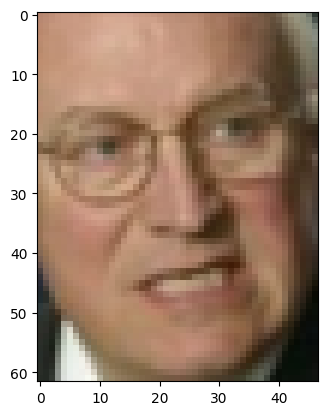

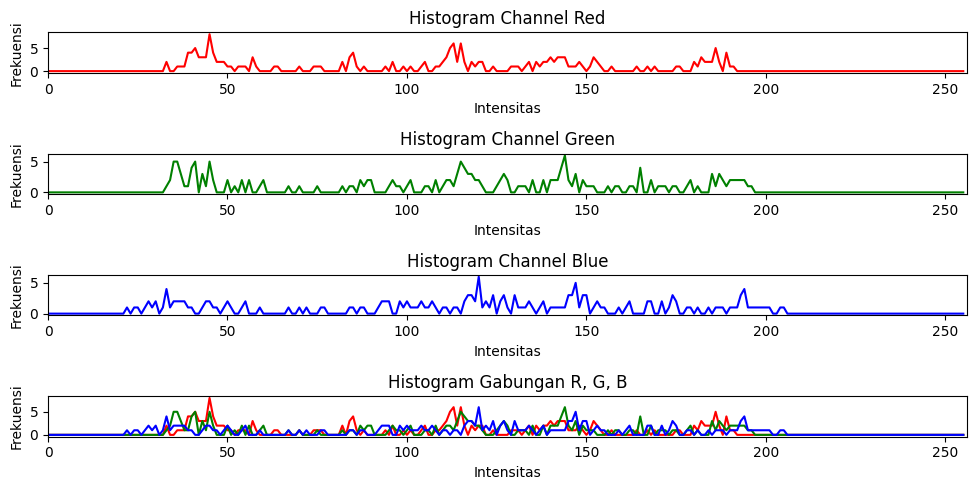

In [8]:
#Visualisasi Data Histogram

#Test Random Image
rand_image = [np.random.randint(0, len(faces.images))]
plt.imshow(faces.images[rand_image[0]])

images_uint8 = (faces.images * 255).astype(np.uint8)

# Menghitung histogram untuk setiap channel
hist_r, _ = np.histogram(images_uint8[rand_image[0], :, 0], bins=256, range=(0, 255))
hist_g, _ = np.histogram(images_uint8[rand_image[0], :, 1], bins=256, range=(0, 255))
hist_b, _ = np.histogram(images_uint8[rand_image[0], :, 2], bins=256, range=(0, 255))

# Membuat subplot untuk visualisasi histogram
plt.figure(figsize=(10, 5))

# Histogram untuk channel Red
plt.subplot(411)
plt.plot(hist_r, color='red')
plt.title('Histogram Channel Red')
plt.xlabel('Intensitas')
plt.ylabel('Frekuensi')
plt.xlim([0, 256])

# Histogram untuk channel Green
plt.subplot(412)
plt.plot(hist_g, color='green')
plt.title('Histogram Channel Green')
plt.xlabel('Intensitas')
plt.ylabel('Frekuensi')
plt.xlim([0, 256])

# Histogram untuk channel Blue
plt.subplot(413)
plt.plot(hist_b, color='blue')
plt.title('Histogram Channel Blue')
plt.xlabel('Intensitas')
plt.ylabel('Frekuensi')
plt.xlim([0, 256])

#Histogram Gabungan
plt.subplot(414)
plt.plot(hist_r, color='red')
plt.plot(hist_g, color='green')
plt.plot(hist_b, color='blue')
plt.title('Histogram Gabungan R, G, B')
plt.xlabel('Intensitas')
plt.ylabel('Frekuensi')
plt.xlim([0, 256])

# Menampilkan histogram
plt.tight_layout()
plt.show()

# Build Model

Pada bagian ini lakukan proses pembuatan model,

1. Pembuatan data training dan data testing
2. Pembuatan objek model
3. Proses fitting model

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [10]:
# Membagi data menjadi data train dan data test
X_train, X_test, y_train, y_test = train_test_split(histogram_features, faces.target, test_size=0.3, random_state=42)

print(f'Train data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')

Train data shape: (3026, 96)
Test data shape: (1298, 96)


In [11]:
# Membuat objek model SVM dengan kernel linear
svc = SVC(kernel='linear', random_state=42)

# Melatih model dengan data training
svc.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

# Evaluation

Pada bagian ini, lakukan evaluasi terhadap data training dan data testing
dengan menggunakan metric akurasi dan juga classfication report

Hints:
Anda dapat menggunakan referensi Jobseet 4 Percobaan 5

In [12]:
from sklearn.metrics import accuracy_score, classification_report

In [13]:
# Prediksi pada data training
y_train_pred = svc.predict(X_train)

# Menghitung akurasi pada data training
train_accuracy = accuracy_score(y_train, y_train_pred)

# Laporan klasifikasi pada data training
report = classification_report(y_train, y_train_pred, target_names=faces.target_names, zero_division=0) # "zero_division=1" = akan menggantikan nilai presisi dan recall yang tidak terdefinisi dengan 1

# Output hasil evaluasi pada data training
print(f'Training Accuracy: {train_accuracy:.2f}')
print('Training Classification Report:')
print(report)

Training Accuracy: 0.12
Training Classification Report:
                           precision    recall  f1-score   support

             Abdullah Gul       0.00      0.00      0.00        13
             Adrien Brody       0.00      0.00      0.00        10
         Alejandro Toledo       0.00      0.00      0.00        32
             Alvaro Uribe       0.00      0.00      0.00        24
          Amelie Mauresmo       0.00      0.00      0.00        14
             Andre Agassi       0.00      0.00      0.00        32
             Andy Roddick       0.00      0.00      0.00        10
           Angelina Jolie       0.00      0.00      0.00        17
              Ann Veneman       0.00      0.00      0.00         8
          Anna Kournikova       0.00      0.00      0.00         9
            Ari Fleischer       0.00      0.00      0.00         8
             Ariel Sharon       0.00      0.00      0.00        57
    Arnold Schwarzenegger       0.00      0.00      0.00        21
     

In [14]:
# Prediksi pada data testing
y_test_pred = svc.predict(X_test)

# Menghitung akurasi pada data testing
test_accuracy = accuracy_score(y_test, y_test_pred)

# Laporan klasifikasi pada data testing
report = classification_report(y_test, y_test_pred, target_names=faces.target_names, zero_division=0 ) # "zero_division=1" = akan menggantikan nilai presisi dan recall yang tidak terdefinisi dengan 1

# Output hasil evaluasi pada data testing
print(f'Test Accuracy: {test_accuracy:.2f}')
print('Test Classification Report:')
print(report)

Test Accuracy: 0.13
Test Classification Report:
                           precision    recall  f1-score   support

             Abdullah Gul       0.00      0.00      0.00         6
             Adrien Brody       0.00      0.00      0.00         2
         Alejandro Toledo       0.00      0.00      0.00         7
             Alvaro Uribe       0.00      0.00      0.00        11
          Amelie Mauresmo       0.00      0.00      0.00         7
             Andre Agassi       0.00      0.00      0.00         4
             Andy Roddick       0.00      0.00      0.00         5
           Angelina Jolie       0.00      0.00      0.00         3
              Ann Veneman       0.00      0.00      0.00         3
          Anna Kournikova       0.00      0.00      0.00         3
            Ari Fleischer       0.00      0.00      0.00         5
             Ariel Sharon       0.00      0.00      0.00        20
    Arnold Schwarzenegger       0.00      0.00      0.00        21
     Atal Bih

# Model : RBF (Kernel non-linear )
# Fitur Histogram

In [15]:
from sklearn.model_selection import GridSearchCV

# Membagi data menjadi data train dan data test
X_train, X_test, y_train, y_test = train_test_split(histogram_features, faces.target, test_size=0.3, random_state=42)

print(f'Train data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')

# Define parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

# Create SVM classifier
svc = SVC(random_state=42)

# Perform grid search
grid_search = GridSearchCV(svc, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on test data
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Generate classification report
report = classification_report(y_test, y_pred, target_names=faces.target_names, zero_division=0)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

Train data shape: (3026, 96)
Test data shape: (1298, 96)
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy: 0.13
Classification Report:
                           precision    recall  f1-score   support

             Abdullah Gul       0.00      0.00      0.00         6
             Adrien Brody       0.00      0.00      0.00         2
         Alejandro Toledo       0.00      0.00      0.00         7
             Alvaro Uribe       0.00      0.00      0.00        11
          Amelie Mauresmo       0.00      0.00      0.00         7
             Andre Agassi       0.00      0.00      0.00         4
             Andy Roddick       0.00      0.00      0.00         5
           Angelina Jolie       0.00      0.00      0.00         3
              Ann Veneman       0.00      0.00      0.00         3
          Anna Kournikova       0.00      0.00      0.00         3
            Ari Fleischer       0.00      0.0

# Fitur lain : Histogram of Oriented Gradients (HOG)
# Model Kernel Linear

In [16]:
from skimage import color
from skimage.feature import hog

# Fungsi extraksi fitur hog
def extract_hog_features(images, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    hog_features = []
    for image in images:
        # Covert gambar ke grayscale jika memilki lebih dari 2 dimensi
        if image.ndim > 2:
            image = color.rgb2gray(image)
        fd = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                 cells_per_block=cells_per_block, visualize=False)
        hog_features.append(fd)
    return np.array(hog_features)

# Extrak fitur HOG
hog_features = extract_hog_features(faces.images)

# Membagi data menjadi data train dan data test
X_train, X_test, y_train, y_test = train_test_split(hog_features, faces.target, test_size=0.3, random_state=42)

# Membuat objek model SVM dengan kernel linear
svc = SVC(kernel='linear', random_state=42)

# Melatih model dengan data training
svc.fit(X_train, y_train)

# Prediksi pada data testing
y_test_pred = svc.predict(X_test)

# Menghitung akurasi pada data testing
test_accuracy = accuracy_score(y_test, y_test_pred)

# Laporan klasifikasi pada data testing
report = classification_report(y_test, y_test_pred, target_names=faces.target_names, zero_division=0)

# Output hasil evaluasi pada data testing
print(f'Test Accuracy: {test_accuracy:.2f}')
print('Test Classification Report:')
print(report)

Test Accuracy: 0.55
Test Classification Report:
                           precision    recall  f1-score   support

             Abdullah Gul       0.43      0.50      0.46         6
             Adrien Brody       0.50      0.50      0.50         2
         Alejandro Toledo       0.40      0.86      0.55         7
             Alvaro Uribe       0.60      0.55      0.57        11
          Amelie Mauresmo       0.75      0.43      0.55         7
             Andre Agassi       0.17      0.75      0.27         4
             Andy Roddick       1.00      0.60      0.75         5
           Angelina Jolie       0.10      0.33      0.15         3
              Ann Veneman       1.00      0.33      0.50         3
          Anna Kournikova       0.33      0.33      0.33         3
            Ari Fleischer       0.00      0.00      0.00         5
             Ariel Sharon       0.48      0.75      0.59        20
    Arnold Schwarzenegger       0.67      0.29      0.40        21
     Atal Bih